# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [6]:
from spacerocks import Units, SpaceRock, Observe, Propagate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
%matplotlib inline

You can also pass in just a single object or an array of objects. I'll try all of the TNOs reported to the MPC. I specified an observatory code, so a topocentric correction will be applied to the Earth's position.

### Analyzing all of the TNOs in the MPC

In [13]:
TNOs = pd.read_json('https://minorplanetcenter.net/Extended_Files/distant_extended.json.gz')
TNOs = TNOs[TNOs.a * (1 - TNOs.e) > 30]
ETNOs = TNOs[TNOs.a > 230]
#TNOs = TNOs[TNOs.Principal_desig.values.astype(str) == '2015 BP519']
units = Units()
rocks = SpaceRock(a=TNOs.a.values, 
                  e=TNOs.e.values, 
                  inc=TNOs.i.values, 
                  arg=TNOs.Peri.values, 
                  node=TNOs.Node.values, 
                  t_peri=TNOs.Tp.values, 
                  epoch=TNOs.Epoch.values,
                  H=TNOs.H.values, 
                  name=TNOs.Principal_desig.values,
                  #delta_H = np.random.rand(len(TNOs)),
                  #rotation_period = np.random.uniform(0.2, 0.5, len(TNOs)),
                  #phi0 = np.random.rand(len(TNOs)) * 2 * np.pi,
                  input_frame='heliocentric',
                  units=units)

erocks = SpaceRock(a=ETNOs.a.values, 
                   e=ETNOs.e.values, 
                   inc=ETNOs.i.values, 
                   arg=ETNOs.Peri.values, 
                   node=ETNOs.Node.values, 
                   t_peri=ETNOs.Tp.values, 
                   epoch=ETNOs.Epoch.values,
                   H=ETNOs.H.values, 
                   name=ETNOs.Principal_desig.values,
                   #delta_H = np.random.rand(len(TNOs)),
                   #rotation_period = np.random.uniform(0.2, 0.5, len(TNOs)),
                   #phi0 = np.random.rand(len(TNOs)) * 2 * np.pi,
                   input_frame='heliocentric',
                   units=units)

#p = Propagate(rocks, np.linspace(2378480.5, 2378480.5 + 10, 10), model=1)

#obs_decam = Observe(p, obscode='W84', NSIDE=[128])
#obs_magellan = Observe(p, obscode=304, NSIDE=[256])
#obs_geocenter = Observe(p)

In [14]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

In [15]:
etnos = pd.read_csv('/Users/kjnapier/research/tnos/clustering/Data/Barycentric_ETNOs.csv')
etnos = etnos[etnos.name != '2013 RF98']
uo5m93 = etnos[etnos.name == 'uo5m93']

# get uo5m93
units = Units()
units.angle = u.rad
etnos = pd.read_csv('/Users/kjnapier/research/tnos/clustering/Data/Barycentric_ETNOs.csv')
etnos = etnos[etnos.name == 'uo5m93']
t = Time('2015-05-21T07:49:26.400', format='isot', scale='utc')
uo5m93 = SpaceRock(a=uo5m93.a.values, 
                 e=uo5m93.e.values, 
                 inc=uo5m93.inc.values, 
                 node=uo5m93.node.values, 
                 arg=uo5m93.arg.values, 
                 M=uo5m93.M.values,
                 epoch=uo5m93.epoch.values, 
                 name=uo5m93.name.values,
                 units=units,
                 input_coordinates='keplerian',
                 input_frame='barycentric')

uo5m93 = Propagate(uo5m93, obsdates=t.jd, model=5)

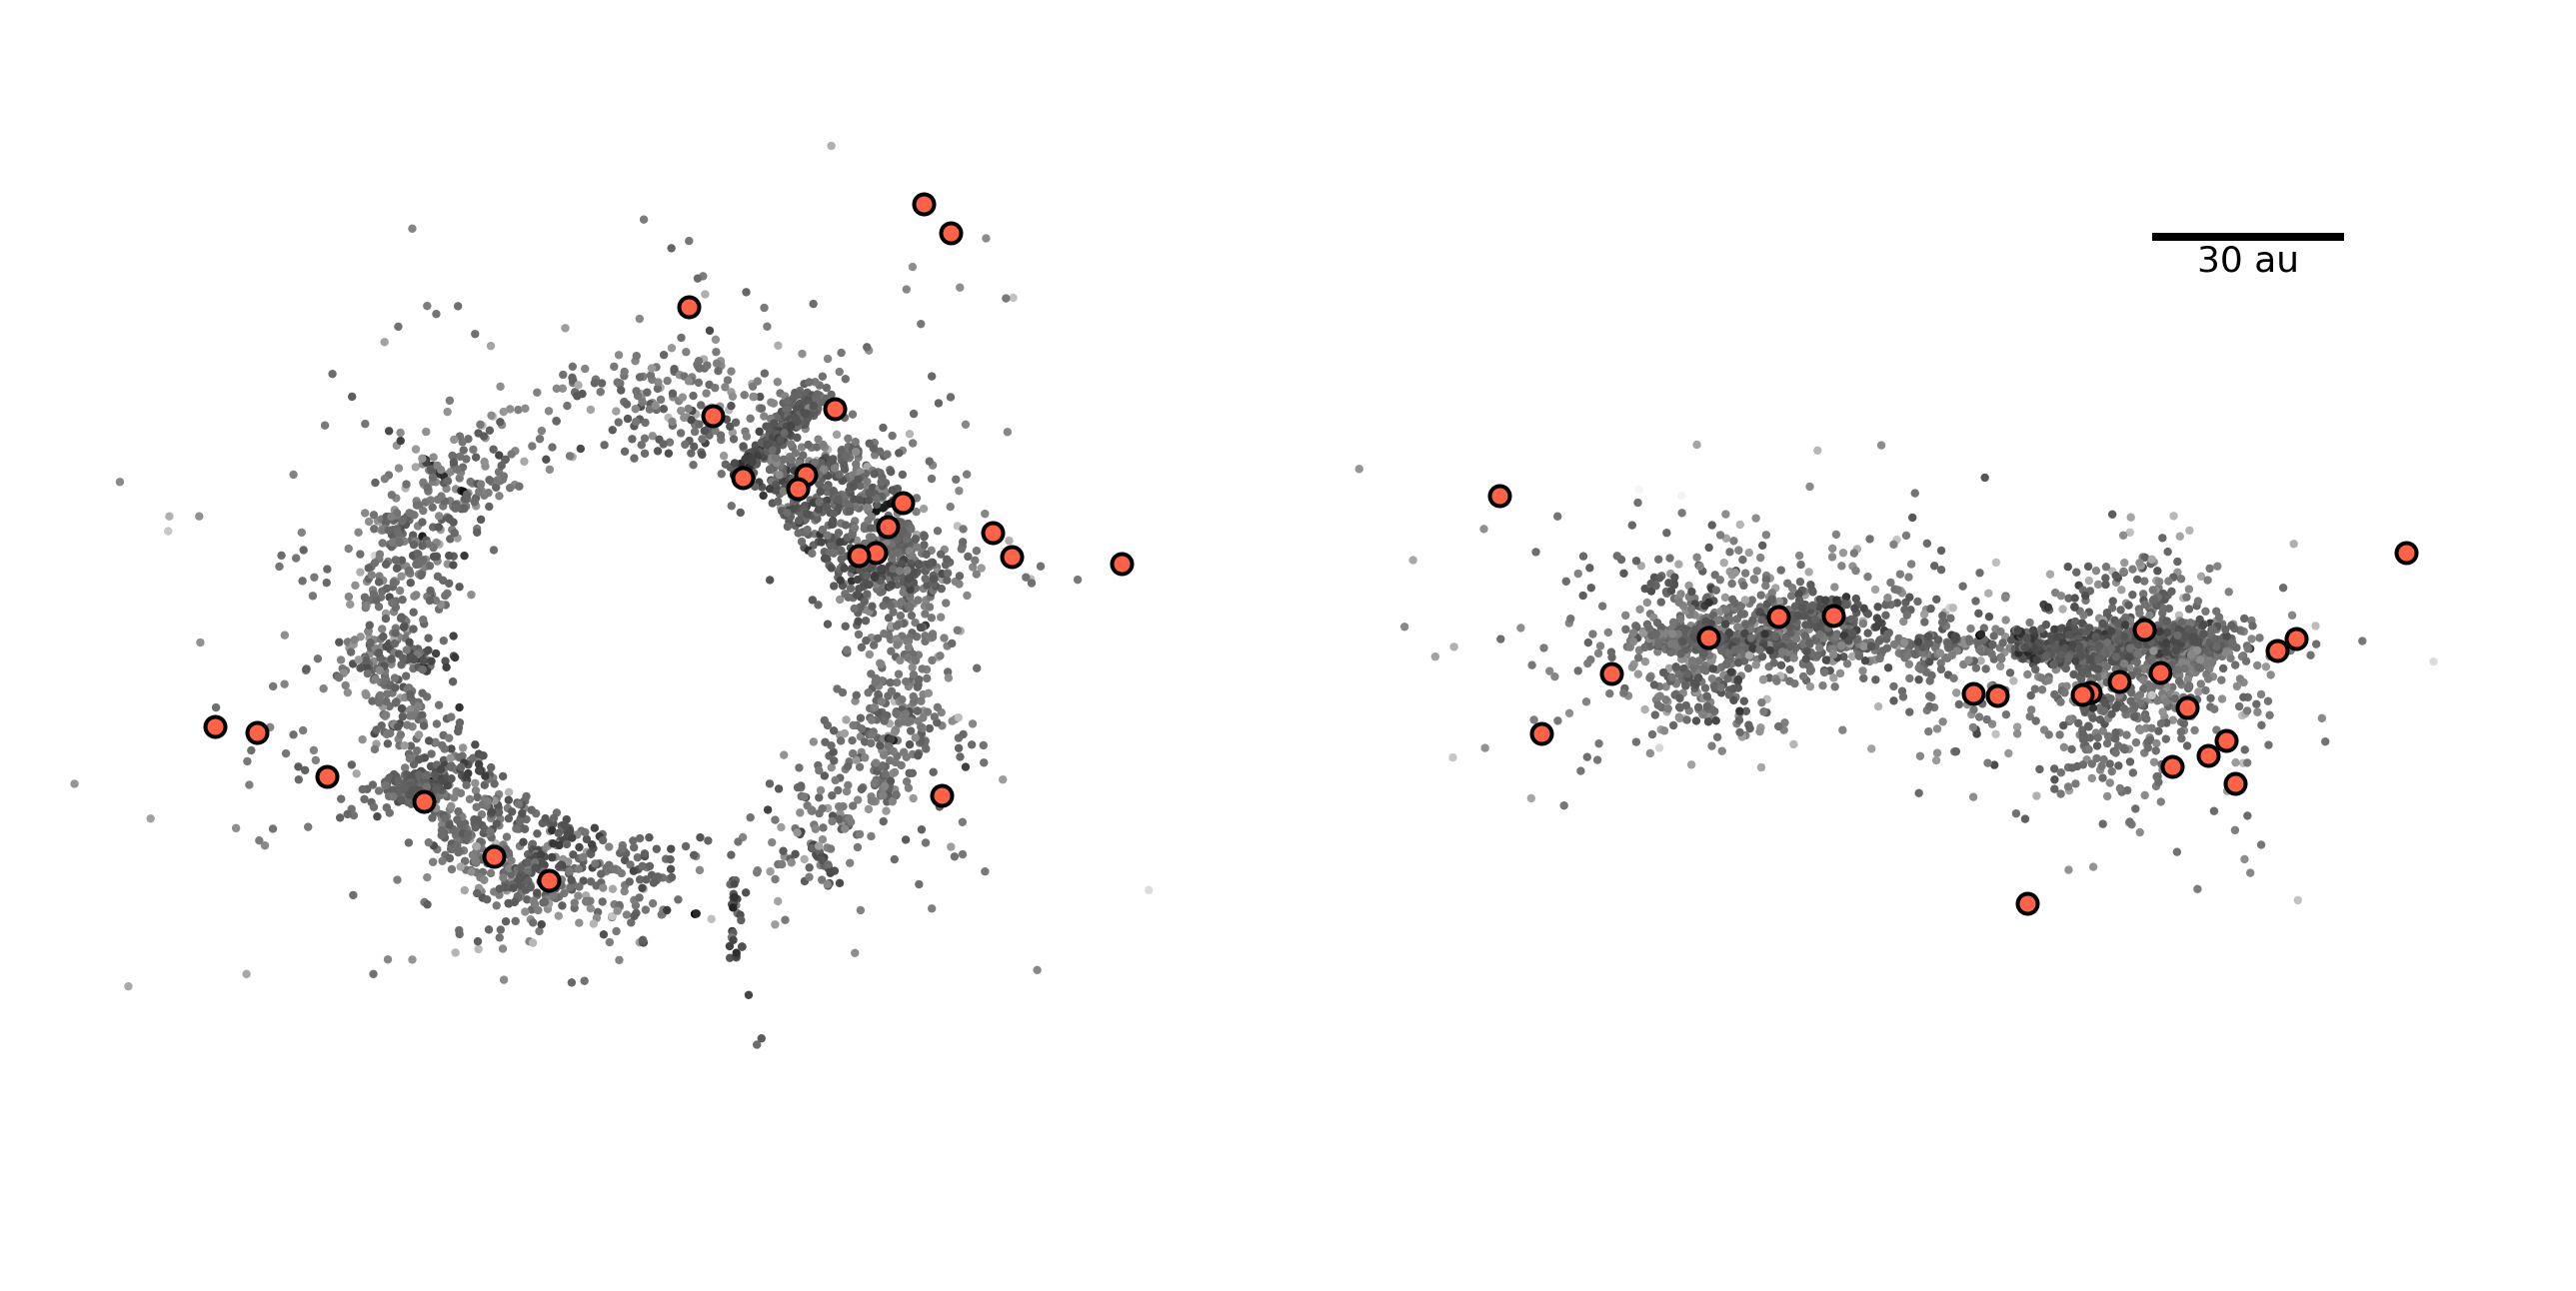

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
ax[0].scatter(rocks.x, rocks.y, s=10, c=rocks.H, cmap='Greys')
ax[0].scatter(erocks.x, erocks.y, s=100, color='tomato', edgecolor='black', linewidth=2)
ax[0].scatter(uo5m93.x, uo5m93.y, s=100, color='tomato', edgecolor='black', linewidth=2)
ax[1].scatter(rocks.x, rocks.z, s=10, c=rocks.H, cmap='Greys')
ax[1].scatter(erocks.x, erocks.z, s=100, color='tomato', edgecolor='black', linewidth=2)
ax[1].scatter(uo5m93.x, uo5m93.z, s=100, color='tomato', edgecolor='black', linewidth=2)


ax[0].set_xlim([-100, 100])
ax[0].set_ylim([-100, 100])
ax[1].set_xlim([-100, 100])
ax[1].set_ylim([-100, 100])
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')


scalebar = AnchoredSizeBar(ax[1].transData,
                           30, '30 au', 
                           loc='upper right', 
                           pad=6,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax[1].add_artist(scalebar)

fig.tight_layout()

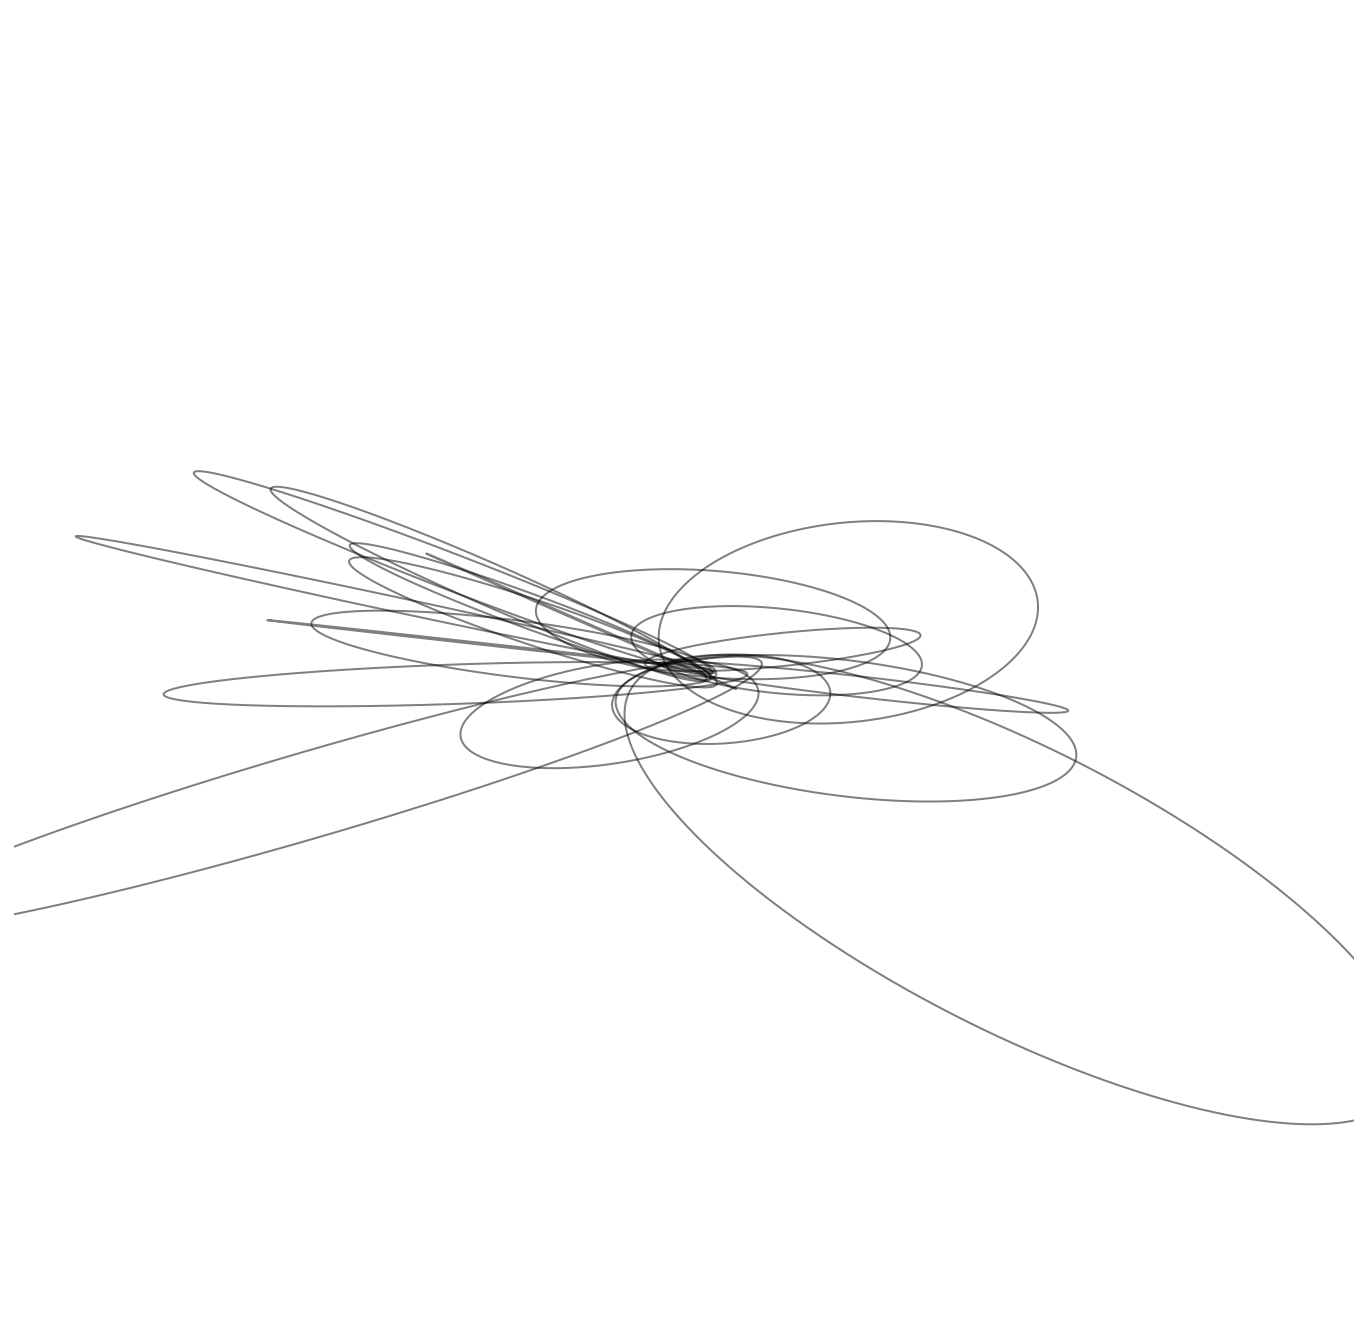

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))
erocks.plot_orbits(5000, colors=['black'] * len(erocks), alphas=[0.5]*len(erocks), ax=ax, linewidths=[1]*len(erocks))
ax.axis('off')
ax.set_xlim([-1000, 1000])
ax.set_ylim([-1000, 1000]);

In [ ]:
from astropy import units as u

In [ ]:
fig, ax = erocks.plot_orbits(5000, colors=['black'] * len(erocks), alphas=[0.5]*len(erocks))
#ax.scatter(erocks.x, erocks.y, s=50, edgecolor='black', zorder=3)
ax.set_xlim([-1000, 1000])
ax.set_ylim([-1000, 1000])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(rocks.x, rocks.y, s=10, c=TNOs.H.values, cmap='Greys_r')
ax.scatter(erocks.x, erocks.y, s=50, color='red', edgecolor='black')

ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
ax.axis('off')

In [ ]:
def kuiper_test(sim, obs):
    return max(sim - obs) + abs(min(sim - obs))

def calc_P(df, obs):
    values = []
    
    simdata = np.arctan2(df.y, df.x).value
    obsdata = np.arctan2(obs.y, obs.x).value

    simcounts, simbins = np.histogram(simdata, bins=1000, density=True, range=[-np.pi, np.pi])
    obscounts, obsbins = np.histogram(obsdata, bins=1000, density=True, range=[-np.pi, np.pi])
    simbins_dx = simbins[1] - simbins[0]
    obsbins_dx = obsbins[1] - obsbins[0]
    real_value = kuiper_test(np.cumsum(simcounts)*simbins_dx, np.cumsum(obscounts)*obsbins_dx)
    print(real_value)
    
    x = rocks.x.value
    y = rocks.y.value
    for ii in range(int(10000)):
        sample = np.random.randint(0, len(x), len(obs))
        sampledata = np.arctan2(df.y[sample], df.x[sample]).value
        samplecounts, samplebins = np.histogram(sampledata, bins=1000,
                                                density=True, range=[-np.pi, np.pi])
        samplebins_dx = samplebins[1] - samplebins[0]
        values.append(kuiper_test(np.cumsum(simcounts)*simbins_dx, np.cumsum(samplecounts)*samplebins_dx))

    return len(np.where(real_value > values)[0])/len(values)

In [ ]:
calc_P(rocks, erocks)

In [ ]:
_ = plt.hist(np.arctan2(rocks.y, rocks.x).value, bins=25, density=True, color='grey', 
             cumulative=True, histtype='step')
_ = plt.hist(np.arctan2(erocks.y, erocks.x).value, cumulative=True, bins=25, histtype='step', density=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(rocks.x, rocks.z, s=5, c=TNOs.H.values, cmap='Greys')
#ax.scatter(erocks.x, erocks.z, s=50, edgecolor='black', color='red')

ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
ax.axis('off')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(rocks.y, rocks.z, s=5, c=TNOs.H.values, cmap='Greys')
ax.scatter(erocks.y, erocks.z, s=50, edgecolor='black', color='red')
ax.axis('off')
ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])

In [ ]:
rocks.

In [ ]:
plt.scatter(obs_decam.ra, obs_decam.dec)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(obs_decam.epoch.jd, obs_decam.mag)#, #color='black', zorder=1)
#ax.plot(obs_decam_norot.epoch.jd, obs_decam_norot.mag, color='red', zorder=2)
ax.set_ylabel('Apparent Magnitude', fontsize=14, labelpad=20)
ax.set_xlabel('JD', fontsize=14, labelpad=10)
#ax.set_xlim([2378480.5, 2378490.5])
#ax.set_ylim([27, 27.5])

In [ ]:
rarate = obs_geocenter.ra_rate.to(u.arcsec / u.hour)
decrate = obs_geocenter.dec_rate.to(u.arcsec / u.hour)

In [ ]:
np.sqrt(rarate**2 + decrate**2)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
_ = ax.hist(np.sqrt(rarate**2 + decrate**2).value, bins=100)
ax.set_xlabel(r'Rate of motion (arcsec per hour)', fontsize=14, labelpad=10)

In [ ]:
rocks = rocks[rocks.e > 0.001]

In [ ]:
rocks2 = SpaceRock(x=rocks.x.value, 
                   y=rocks.y.value, 
                   z=rocks.z.value, 
                   vx=rocks.vx.value, 
                   vy=rocks.vy.value, 
                   vz=rocks.vz.value,
                   epoch=rocks.epoch.jd,
                   H=rocks.H, 
                   name=rocks.name,
                   input_coordinates='cartesian',
                   input_frame='heliocentric',
                   input_angles='degrees')

In [ ]:
from astroquery.jplhorizons import Horizons

In [ ]:
Nyears = 10
startdate = Time('2017-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + Nyears*365.25, 1), scale='utc', format='jd' )
tno_id = 'Ceres'
TNO_Horizons = Horizons(id=tno_id)
elements = TNO_Horizons.elements()[0]
ephem_Horizons = Horizons(id=tno_id, location='W84',
                          epochs={'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'1d'}).ephemerides()
TNO = SpaceRock(a=elements['a'],
                e=elements['e'],
                inc=elements['incl'],
                arg=elements['w'],
                node=elements['Omega'],
                t_peri=elements['Tp_jd'],
                epoch=elements['datetime_jd'],
                name=[tno_id],
                input_frame='heliocentric',
                units=units)
TNO_prop = Propagate(TNO, obsdates=testdates.jd, model=5)
TNO_predict = Observe(TNO_prop, obscode='W84')
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(TNO_predict.ra.deg, TNO_predict.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)

In [ ]:
elem = Horizons(id=tno_id, epochs={'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'1d'}).elements()

In [ ]:
TNO_prop.epoch[0]

In [ ]:
elem['a'][0]

In [ ]:
print(elem['datetime_jd'][0], TNO_prop.epoch[0])

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['a'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.a, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('a', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['incl'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.inc.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('inc', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['e'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.e, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('inc', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, (elem['incl'] - TNO_prop.inc.deg), color='black', s=1)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('inc residuals (arcsec)', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, (elem['a'] - TNO_prop.a), color='black', s=1)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('a residual', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA_rate'], color='black', s=50)
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.ra_rate.to(u.arcsec/u.h), color='red', s=10)
ax[0].set_xlabel('JD', fontsize=14)
ax[0].set_ylabel('ra rate (arcsec/h)', fontsize=14)
ax[0].set_xlim([0, Nyears]);

ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['DEC_rate'], color='black', s=50)
ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.dec_rate.to(u.arcsec/u.h), color='red', s=10)
ax[1].set_xlabel('JD', fontsize=14)
ax[1].set_ylabel('dec rate (arcsec/h)', fontsize=14)
ax[1].set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, 
              ephem_Horizons['RA_rate'] - TNO_predict.ra_rate.to(u.arcsec/u.h), color='black', s=1)
ax[0].set_xlabel('JD', fontsize=14)
ax[0].set_ylabel('ra rate (arcsec/h)', fontsize=14)
ax[0].set_xlim([0, Nyears]);

ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, 
              ephem_Horizons['DEC_rate'] - TNO_predict.dec_rate.to(u.arcsec/u.h), color='black', s=1)
ax[1].set_xlabel('JD', fontsize=14)
ax[1].set_ylabel('dec rate (arcsec/h)', fontsize=14)
ax[1].set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, sep.arcsec, color='black', s=1)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('Diff Horizons - SpaceRocks', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['elong'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.elong.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('Solar Elongation Angle', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, 
           ephem_Horizons['elong'] - TNO_predict.elong.deg, color='black', s=1)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('Solar Elongation Angle Residual (deg)', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['delta'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.delta, color='red', s=10)

ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('Earth Distance', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.scatter((testdates.jd - testdates.jd[0])/365.25, 
           (TNO_predict.delta - ephem_Horizons['delta']).to(u.km), color='black', s=1)

ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('Earth Distance Residuals (km)', fontsize=14)
ax.set_xlim([0, Nyears]);
#ax.set_ylim([0, 200]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.ra.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('ra', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, 
           (ephem_Horizons['RA'] - TNO_predict.ra.deg) * 3600, color='black', s=1)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('ra residuals (arcsec)', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['DEC'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.dec.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('dec', fontsize=14)
ax.set_xlim([0, Nyears]);

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, 
           (ephem_Horizons['DEC'] - TNO_predict.dec.deg) * 3600, color='black', s=1)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('dec residuals (arcsec)', fontsize=14)
ax.set_xlim([0, Nyears]);

---